# Problem set 3: Optimization and Root Finding: The Consumer Problem

We will take a look at solving the canonical utility maximization problem for the consumer.  

**Problem set structure:** 
* Each problem set consists of tasks and problems. _Tasks_ train you in using specific techniques, while _problems_ train you in solving actual economic problems. 
* Each problem set also contains solutions, which can be found in separate Python files.
* The Python files `A[..].py` do not run out of the box. But you can copy the code into your notebook or user module. 
* *You should really try to solve the tasks and problems on your own before looking at the answers!* 
* You goal should, however, not be to write everything from scratch. 
* Finding similar code from the lectures and adjusting it is completely ok. I rarely begin  completely from scratch, I figure out when I last did something similar and copy in the code to begin with. A quick peak at the solution, and then trying to write the solution yourself is also a very beneficial approach.

**Multiple solutions:** Within the field of numerical analysis there is often many more than one way of solving a specific problem. So the solution provided is just one example. If you get the same result, but use another approach, that might be just as good (or even better).

**Table of contents**<a id='toc0_'></a>    
- [1. Functions](#toc1_)    
- [2. Function continued](#toc2_)    
- [3. Methods to solve and optimize](#toc3_)    
  - [3.1 Brute‑Force Grid Search](#toc3_1_)    
  - [3.2 Bisection](#toc3_2_)    
  - [3.3 Newton's Method](#toc3_3_)    
  - [3.4 scipy.optimize](#toc3_4_)    
- [4. Other Optimizers - Comparing Methods (more difficult)](#toc4_)    
- [5. Sensitivity: Price shock](#toc5_)    
- [6. Sensitivity: Starting Values & Solver Choices](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[1. Functions](#toc0_)

Implement a Python version of this function:

$$ 
u(x_1,x_2) = (\alpha x_1^{-\beta} + (1-\alpha) x_2^{-\beta})^{-1/\beta} 
$$

*Github Check Check*

In [1]:
# set autoreload so that changes in A*.py files are reflected without restarting the notebook
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize
from timeit import default_timer as timer

In [2]:
# Utility function
def utility_ces(x1, x2, alpha=1, beta=0.5):
    if x1 > 0 and x2 > 0:
        return (alpha * x1**-beta + (1 - alpha) * x2**-beta)**(-1/beta)

## <a id='toc2_'></a>[2. Function continued](#toc0_)

Solve the above consumer problem with the CES utility function.

$$
u(x_1,x_2) = (\alpha x_1^{-\beta} + (1-\alpha) x_2^{-\beta})^{-1/\beta}
$$

Subject to the Budget Constraint:
$$ p_1 x_1 + p_2 x_2 \le I, \quad x_1 \ge 0,\; x_2 \ge 0. $$

Tasks: Use your function from above that contains the CES utility function and embed it into another function *value_of_choice_ces* that returns the value of utility *u*.

In [3]:
# Use these baseline parameters
alpha = 0.5
beta = 0.000001
I = 10
p1 = 1
p2 = 2

# Define function - value of choice
def value_of_choice_ces(x1, alpha, beta, p1, p2, I):
    x2 = (I - p1 * x1) / p2
    return utility_ces(x1, x2, alpha, beta)

# Define objective funciton for minimization
obj = lambda x1: -value_of_choice_ces(x1, alpha, beta, p1, p2, I)

Next, we will compare different methods to solve the consumer problem.

## <a id='toc3_'></a>[3. Methods to solve and optimize](#toc0_)

### <a id='toc3_1_'></a>[3.1 Brute‑Force Grid Search](#toc0_)
Set up a grid of the budget set and solve the consumer problem on the grid.

**Idea:** Search over a grid for  $c_1 \in [0, I/p_1]$, and  $c_2 \in [0, I/p_2]$ to find the values of $c_1$ and $c_2$ that maximize utility.


In [4]:
from types import SimpleNamespace
from grid_solve import print_solution

**Task**: Modify the grid search function below to add the additional parameter for the CES utility function $\beta$ and print the results. Note that you also need to use of the utility function. Make sure it runs below.

In [5]:
# Modify to include beta
def find_best_choice(u_func,alpha,beta,I,p1,p2,N1,N2,do_print=True):
    
    # a. allocate numpy arrays
    shape_tuple = (N1,N2)
    x1_values = np.empty(shape_tuple)
    x2_values = np.empty(shape_tuple)
    u_values = np.empty(shape_tuple)
    
    # b. start from guess of x1=x2=0
    x1_best = 0
    x2_best = 0
    u_best = -np.inf # Initialize using a negative infinity instead of a function
    
    # c. loop through all possibilities
    for i in range(N1):
        for j in range(N2):
            
            # i. x1 and x2 (chained assignment)
            x1_values[i,j] = x1 = (i/(N1-1))*I/p1
            x2_values[i,j] = x2 = (j/(N2-1))*I/p2
            
            # ii. utility
            if p1*x1 + p2*x2 <= I: # u(x1,x2) if expenditures <= income 
                u_values[i,j] = u_func(x1,x2,alpha=alpha,beta=beta)
            else: # Negative infinity
                u_values[i,j] = -np.inf

            # iii. check if best sofar
            if u_values[i,j] > u_best:
                x1_best = x1_values[i,j]
                x2_best = x2_values[i,j] 
                u_best = u_values[i,j]
    
    # d. print
    if do_print:
        print_solution(x1_best,x2_best,u_best,I,p1,p2)

    return SimpleNamespace(x1_best=x1_best,x2_best=x2_best,u_best=u_best,x1_values=x1_values,x2_values=x2_values,u_values=u_values)

# Check if it works
N1 = 100
N2 = 100

sol = find_best_choice(utility_ces, alpha, beta, I, p1, p2, N1, N2, do_print=True)

x1 = 4.9495
x2 = 2.5253
u  = 3.5354
I-p1*x1-p2*x2 = -0.00000000
x1*p1/I = 0.4949


### <a id='toc3_2_'></a>[3.2 Bisection](#toc0_)

Use the bisection function from the lecture. Make sure you understand what it does first. Then, define the first‑order condition of the consumer problem with the modified utility function, which we can enforce by a **single equation in $ x_1 $**:  


FOC (interior):
$$\frac{\partial u/\partial x_1}{\partial u/\partial x_2}
=\frac{\alpha\,x_1^{-(\beta+1)}}{(1-\alpha)\,x_2^{-(\beta+1)}}
=\frac{\alpha}{1-\alpha}\left(\frac{x_2}{x_1}\right)^{\beta+1}
=\frac{p_1}{p_2}.$$

Single equation in $x_1$ (with $x_2(x_1)=\tfrac{I-p_1x_1}{p_2}$):
$$F(x_1)\equiv \frac{\alpha}{1-\alpha}\left(\frac{I-p_1x_1}{p_2x_1}\right)^{\beta+1}-\frac{p_1}{p_2}=0.$$

We solve $ F(x_1) = 0 $ on $[0, I/p_1]$ using **bisection**.



**Algorithm:** `bisection()`

1. Set $a_0 = a$ and $b_0 = b$ where $f(a)$ and $f(b)$ has oposite sign, $f(a_0)f(b_0)<0$
2. Compute $f(m_0)$ where $m_0 = (a_0 + b_0)/2$ is the midpoint.
3. Determine the next sub-interval $[a_1,b_1]$:
  * If $f(a_0)f(m_0) < 0$ (different signs) then $a_1 = a_0$ and $b_1 = m_0$ (i.e. focus on the range $[a_0,m_0]$).
  * If $f(m_0)f(b_0) < 0$ (different signs) then $a_1 = m_0$ and $b_1 = b_0$ (i.e. focus on the range $[m_0,b_0]$).
4. Repeat step 2 and step 3 until $|f(m_k)| < \epsilon$.

In [6]:
def bisection(f, a, b, tol=1e-10, max_iter=500):
    fa, fb = f(a), f(b)
    if np.isnan(fa) or np.isnan(fb):
        raise ValueError("f(a) or f(b) is NaN.")
    if fa == 0.0: 
        return a, 0
    if fb == 0.0: 
        return b, 0
    if fa*fb > 0:
        raise ValueError("Bisection: root not bracketed. Choose a,b with opposite signs.")
    it = 0
    while (b - a) > tol and it < max_iter:
        m  = 0.5*(a + b)
        fm = f(m)
        if fm == 0.0:
            a = b = m
            break
        if fa*fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
        it += 1
    return 0.5*(a + b), it

Single equation in $x_1$ (with $x_2(x_1)=\tfrac{I-p_1x_1}{p_2}$):
$$F(x_1)\equiv \frac{\alpha}{1-\alpha}\left(\frac{I-p_1x_1}{p_2x_1}\right)^{\beta+1}-\frac{p_1}{p_2}=0.$$

In [7]:
# Set up the function F(c1) = 0 to solve for c1*
def F(x1, alpha, beta, p1, p2, I):
    return alpha/(1-alpha) * ((I-p1*x1)/(p2*x1))**(beta+1) - p1/p2 

# Choose a bracket around the known solution
a_bis, b_bis = 0.0001, I/p1 - 0.0001

# Set the tolerance and the maximum number of iterations
tol=1e-10
max_iter=500

# Run the bisection method, compute x2 and print the solution
x1_bis, it_bis = bisection(lambda x: F(x, alpha, beta, p1, p2, I), a_bis, b_bis, tol=tol, max_iter=max_iter)
x2_bis = (I - p1*x1_bis) / p2

print(f"Bisection: x1*={x1_bis:.10f}, x2*={x2_bis:.10f}, iterations={it_bis}")

Bisection: x1*=4.9999982672, x2*=2.5000008664, iterations=37


### <a id='toc3_3_'></a>[3.3 Newton's Method](#toc0_)

Apply Newton on $ F(c_1)=0 $ where $F$ is defined above.  
We compute $ F'(c_1)$ analytically for the CES consumer problem:

**Fully expanded form**
$
F'(c_1)\;=\;-\;\frac{\alpha}{1-\alpha}\,(\beta+1)\,\frac{I}{p_2\,c_1^{2}}
\left(\frac{I-p_1 c_1}{p_2\,c_1}\right)^{\beta}.
$

In [8]:
# Fprime function
def Fprime(x1, alpha, beta, p1, p2, I):
    return - alpha/(1 - alpha) * (beta + 1) * I/(p2*x1) * ((I - p1*x1)/(p2*x1))**beta

# Use Newton solver to find the root
def find_root(x0, f, df, tol=1e-12, max_iter=200):
    x = float(x0)
    for it in range(1, max_iter+1):
        fx, dfx = f(x), df(x)
        if not np.isfinite(fx) or not np.isfinite(dfx) or dfx == 0:
            x = 0.5*(x + 0.5*I/p1)  # gentle fallback
            continue
        x_new = x - fx/dfx
        if x_new <= 0 or x_new >= I/p1 or not np.isfinite(x_new):
            x_new = 0.5*(x + 0.5*I/p1)
        if abs(x_new - x) < tol:
            return x_new, it
        x = x_new
    return x, max_iter

# Run Newton
x0 = 0.4 * (I/p1)
x1_newt, it_newt = find_root(x0, lambda x: F(x, alpha, beta, p1, p2, I), lambda x: Fprime(x, alpha, beta, p1, p2, I), tol=1e-12)
x2_newt = (I - p1*x1_newt) / p2

print(f"Newton: x1*={x1_newt:.10f}, x2*={x2_newt:.10f}, iterations={it_newt}")


Newton: x1*=4.9999982671, x2*=2.5000008664, iterations=118


### <a id='toc3_4_'></a>[3.4 scipy.optimize](#toc0_)

Solve the consumer problem now using the scipy.minimize_scalar function. Define adequate bounds.



In [9]:
# Baseline parameters
alpha = 0.5
beta = 0.000001
I = 10
p1 = 1
p2 = 2

# Set bounds
bounds = (0, I/p1)  # bounds for x1

# Set objective function
obj = lambda x1: -value_of_choice_ces(x1, alpha, beta, p1, p2, I)

# Run minimize scalar
res = optimize.minimize_scalar(obj, bounds=bounds, method='bounded')

# Extract optimal x-values
x1_optimal = res.x
x2_optimal = (I - p1 * x1_optimal) / p2

# Extract optimal utility
u_optimal = -res.fun

# Print solution
print(f"SciPy minimize_scalar: x1*={x1_optimal:.10f}, x2*={x2_optimal:.10f}, u*={u_optimal:.10f}")

SciPy minimize_scalar: x1*=4.9999581891, x2*=2.5000209055, u*=3.5355336936



## <a id='toc4_'></a>[4. Other Optimizers - Comparing Methods (more difficult)](#toc0_)

Solve the problem now with *SLSQP* and compare the number of iterations, function evaluations, speed, and precision with *Nelder-Mead*.


This holds:


nfev: number of function evaluations


njev: number of Jacobian evaluations


nit: number of iterations of the algorithm

In [10]:
# Optimize with SLSQP instead

# Set initial guess
x1_initial = I / (2 * p1)  # midpoint of the bounds

# Set bounds
bounds = [(0, I/p1)]  # bounds for x1

# Start time
start_time = timer()

# Run minimize with SLSQP
res_slsqp = optimize.minimize(obj, x1_initial, method='SLSQP', bounds=bounds)

# End time
end_time = timer()

# Extract optimal x-values
x1_optimal_slsqp = res_slsqp.x[0]
x2_optimal_slsqp = (I - p1 * x1_optimal_slsqp) / p2

# Extract optimal utility
u_optimal_slsqp = -res_slsqp.fun

# Print solution
print(f"SciPy SLSQP: {res_slsqp},\n Num of secs: {end_time - start_time}")

SciPy SLSQP:  message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.535533693620822
       x: [ 5.000e+00]
     nit: 1
     jac: [ 0.000e+00]
    nfev: 2
    njev: 1,
 Num of secs: 0.000542207999387756


In [11]:
# Optimize with nelder-mead instead

# Set initial guess
x1_initial = I / (2 * p1)  # midpoint of the bounds

# Set bounds
bounds = [(0, I/p1)]  # bounds for x1

# Time it
start_time = timer()

# Run minimize with nelder-mead
res_nelder = optimize.minimize(obj, x1_initial, method='Nelder-Mead', bounds=bounds)

# End time
end_time = timer()

# Extract optimal x-values
x1_optimal_nelder = res_nelder.x[0]
x2_optimal_nelder = (I - p1 * x1_optimal_nelder) / p2

# Extract optimal utility
u_optimal_nelder = -res_nelder.fun

# Print solution
print(f"SciPy Nelder-Mead: {res_nelder},\n Num of secs: {end_time - start_time}")

SciPy Nelder-Mead:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -3.535533693620822
             x: [ 5.000e+00]
           nit: 13
          nfev: 26
 final_simplex: (array([[ 5.000e+00],
                       [ 5.000e+00]]), array([-3.536e+00, -3.536e+00])),
 Num of secs: 0.0006984170177020133


## <a id='toc5_'></a>[5. Sensitivity: Price shock](#toc0_)

- Now, assume that the price p1 doubles. Recompute (x1_star, x2_star, u_star) for each $\beta$.
- For each $\beta$, compute percentage changes relative to baseline.
- Plot two panels, where panel A contains quantities (the percentage change in x1_star and x2_star) and panel B contains the percentage change in u_star.
- Interpretation: Briefly explain how the substitution elasticity (lower beta) shapes x1_star, x2_star, and the utility.

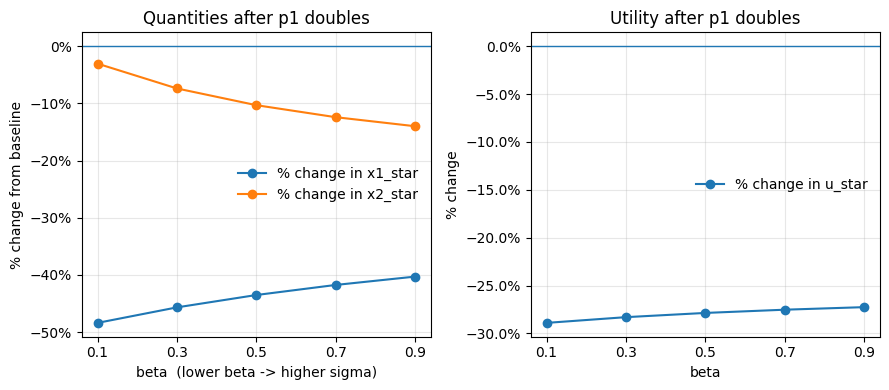

In [15]:
# --- CES consumer: price shock sensitivity (p1 doubles) ---
# Utility: u(x1,x2) = (alpha * x1^(-beta) + (1 - alpha) * x2^(-beta))^(-1/beta)
# Elasticity of substitution: sigma = 1 / (1 + beta)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Parameters 
# Use these baseline parameters
alpha = 0.5
beta = 0.000001
I = 10
p1 = 1
p2 = 2

betas    = np.array([0.1, 0.3, 0.5, 0.7, 0.9])  # five beta values in (0,1)

# ----- helpers -----
def sigma_from_beta(beta):
    # elasticity of substitution
    return 1.0 / (1.0 + beta)

def ces_demands(I, p1, p2, alpha, beta):
    """
    Returns (x1_star, x2_star, u_star, s1, s2) using CES duality.

    Indirect utility: u_star = I / C(p),
    where C(p) = [ alpha^sigma * p1^(1 - sigma) + (1 - alpha)^sigma * p2^(1 - sigma) ]^(1 / (1 - sigma))

    Budget shares:
      s1 = alpha^sigma * p1^(1 - sigma) / denom
      s2 = 1 - s1
    """
    sigma = sigma_from_beta(beta)
    denom = (alpha**sigma) * (p1**(1.0 - sigma)) + ((1.0 - alpha)**sigma) * (p2**(1.0 - sigma))
    s1 = (alpha**sigma) * (p1**(1.0 - sigma)) / denom
    s2 = 1.0 - s1
    x1 = (I / p1) * s1
    x2 = (I / p2) * s2
    C  = denom**(1.0 / (1.0 - sigma))
    u  = I / C
    return x1, x2, u, s1, s2

# ----- baseline vs. shock (p1 doubles) -----
base = np.array([ces_demands(I, p1,     p2, alpha, b) for b in betas]).T
shck = np.array([ces_demands(I, 2.0*p1, p2, alpha, b) for b in betas]).T

x1_b, x2_b, u_b = base[0], base[1], base[2]
x1_s, x2_s, u_s = shck[0], shck[1], shck[2]

pct = lambda new, old: 100.0 * (new - old) / old
d_x1 = pct(x1_s, x1_b)
d_x2 = pct(x2_s, x2_b)
d_u  = pct(u_s,  u_b)

# ----- plots -----

# plots
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)

# Panel A: quantities
axs[0].plot(betas, d_x1, marker='o', label='% change in x1_star')
axs[0].plot(betas, d_x2, marker='o', label='% change in x2_star')
axs[0].set_title('Quantities after p1 doubles')
axs[0].set_xlabel('beta  (lower beta -> higher sigma)')
axs[0].set_ylabel('% change from baseline')
axs[0].axhline(0, linewidth=1)
axs[0].yaxis.set_major_formatter(PercentFormatter())
axs[0].set_xticks(betas.tolist())
axs[0].grid(True, alpha=0.3)
axs[0].legend(frameon=False)

# Panel B: utility
axs[1].plot(betas, d_u, marker='o', label='% change in u_star')
axs[1].set_title('Utility after p1 doubles')
axs[1].set_xlabel('beta')
axs[1].set_ylabel('% change')
axs[1].axhline(0, linewidth=1)
axs[1].yaxis.set_major_formatter(PercentFormatter())
axs[1].set_xticks(betas.tolist())
axs[1].grid(True, alpha=0.3)
axs[1].legend(frameon=False)

plt.tight_layout()
plt.show()

## <a id='toc6_'></a>[6. Sensitivity: Starting Values & Solver Choices](#toc0_)

- Try different starting values for Newton and `minimize`.
- Discuss your main observations and take-aways regarding number of iterations and function evaluations.
- Which one was your favorite solver in this application? Why?


In [13]:

# Try out and discuss